In [71]:
from PIL import Image, ImageDraw, ImageFont, ImageOps
import numpy as np
from numpy import fft, rot90 
from collections import OrderedDict
import os
import sys
from tqdm import tqdm

Ustalam konkretną czcionkę i konkretny jej rozmiar

In [72]:
font_size = 30
font_path = "fonts/times-new-roman.ttf"

Na podstawie zdjęcia całego alfabetu tej cznionki tworzę pojedyńcze zdjęcia liter, cyfr i znaków diakrytycznych. 

In [73]:
def cut_photo(image):
    image_array = np.array(image)
    top = -1
    bottom = -1
    left = -1
    right = -1
    for i in range(image_array.shape[0]):
        cnt = 0
        for j in range(image_array.shape[1]):
            if image_array[i][j] == 0:
                cnt += 1
        if cnt != 0:
            if top == -1:
                top = i
    for i in range(image_array.shape[0]-1,-1,-1):
        cnt = 0
        for j in range(image_array.shape[1]):
            if image_array[i][j] == 0:
                cnt += 1
        if cnt != 0:
            if bottom == -1:
                bottom = i
    for i in range(image_array.shape[0]):
        cnt = 0
        for j in range(image_array.shape[1]):
            if image_array[j][i] == 0:
                cnt += 1
        if cnt != 0:
            if left == -1:
                left = i
    for i in range(image_array.shape[0]-1,-1,-1):
        cnt = 0
        for j in range(image_array.shape[1]):
            if image_array[j][i] == 0:
                cnt += 1
        if cnt != 0:
            if right == -1:
                right = i

    image2 = image.crop((left-1, top-1, right+1, bottom+1))
    return image2


def create_photo(char, font_path, font_size):
    image = Image.new("L", (font_size+10,font_size+10), 255)
    text = char
    font = ImageFont.truetype(font_path, font_size)

    draw = ImageDraw.Draw(image)

    draw.text((5,5), text, fill=0, font=font)
    final_image = cut_photo(image)
    if char=='.':
        final_image.save("letters/dot.png")
    else:
        final_image.save("letters/"+char+".png")


def create_alfabet_photos(font_path: str, font_size: int) -> None:
    chars = "abcdefghijklmnoprqstuyvwxz0123456789.,?!"
    for char in chars:
        create_photo(char, font_path, font_size)

create_alfabet_photos(font_path, font_size)


Tworze tekst o konkretnym rozmiarze i czcionce, i zapisuje go do zdjęcia z którego będę próbował odczytać ten tekst.

In [74]:
def create_text_image(text, font_size, font_path, file_name="test1.png"):
    width = 700
    height = 200
    image = Image.new("L", (width,height), 255)


    font = ImageFont.truetype(font_path, font_size)

    draw = ImageDraw.Draw(image)

    text_color = 0


    draw.text((20,20), text, fill=text_color, font=font)

    image.save(file_name)
    return image

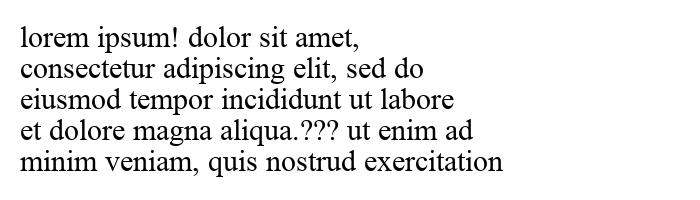

In [75]:
text = """lorem ipsum! dolor sit amet,
consectetur adipiscing elit, sed do
eiusmod tempor incididunt ut labore
et dolore magna aliqua.??? ut enim ad
minim veniam, quis nostrud exercitation"""

create_text_image(text, font_size, font_path)

Tworze funkcje służącą do zliczania jak dużo znaków w tekście zostało wykrytych w stosunku do tego jak dużo zostało wykrytych

In [76]:
def count_letters(alfabet, text_in, text_out):
    text_in_map = {char : 0 for char in alfabet}
    text_out_map = {char : 0 for char in alfabet}
    text_in2 = text_in.split()
    text_in2 = text_in2[::-1]
    text_in2 = "".join(text_in2)


    text_out2 = text_out.split()
    text_out2 = text_out2[::-1]
    text_out2 = "".join(text_out2)
    for char in text_in2:
        text_in_map[char] += 1
    for char in text_out2:
        text_out_map[char] += 1
    for i in sorted(alfabet):
        print(i," w oryginalnym tekście:",text_in_map[i],"| w przeczytanym tekście:",text_out_map[i])


Sposobem na poprawne sortowanie znaków po linijkach jest stworzenie wirtualnej linii która jest liczona jako linia w której wszystkie piksele były czarne. I w ten sposób udaje mi się poprawnie posortować znaki w momencie kiedy tekst ma kilka linijek.

Proces wykonywania OCRA działa następująco:
1) Wczytuje obraz do przeczytania z niego tekstu
2) Tworze tablice visited dla każdego piksela na obrazie
3) Sprawdzam każdą literę pokolei, jeżeli wartość korelacji jakiejś litery z miejscem na obrazie wynosi więcej niż 95%, to wstawiam ją do listy przechowującej jej współrzędne, wirtualną linie, wartość korelacji i jaki był to znak. Przy okazji ustawiam visited wokół tego znaku na true, dlatego jeżeli najpierw w miejscu litery e, zostanie wykryta litera c, to będzie to błędne odczytanie dlatego ważne jest odpowiednia kolejność.

In [77]:
letters_width = {}
letter_thresholds = {
    'dot': 0.98,
    ',': 0.98,
    '!': 0.98,
    'default': 0.95
}

def loadImage(file_name, RGB = False):
    if file_name == ".":
        file_name = "dot"
    image = Image.open(file_name+".png")
    if not RGB:
        image = image.convert("L")
    image = ImageOps.invert(image)
    return image


def calculate_colleration(letters_path, doc_path, alfabet_order):
    alfabet = alfabet_order
    position_letter_map = {}
    position_letter_list = []
    doc_image = loadImage(doc_path)
    visited = [[False for _ in range(doc_image.width)] for _ in range(doc_image.height)]
    for char in tqdm(alfabet):
        if char == ".":
            char = "dot"

        virtual_line = 0
        file_name = letters_path+char
        char_image = loadImage(file_name)
        letters_width[char] = char_image.width
        correlation_matrix = fft.ifft2(fft.fft2(doc_image)*fft.fft2(rot90(rot90(char_image)),s=(doc_image.size[1],doc_image.size[0]))).real
        correlation_matrix /= np.abs(np.max(correlation_matrix))

        threshold = letter_thresholds.get(char, letter_thresholds['default'])
        cnt = 0
        for i, row in enumerate(correlation_matrix):
            for j, value in enumerate(row):
                if value > threshold:
                    if not visited[i][j]:
                        position_letter_map[(i,j)] = [value, char]
                        position_letter_list.append([i,j,virtual_line, value,char])
                        for x in range(-int(char_image.height*0.8),10):
                            for y in range(-int(char_image.width*0.8),5):
                                if (i + x) < 0 or (i + x) >= doc_image.height or (j + y) < 0 or (j + y) >= doc_image.width:
                                    continue
                                visited[i+x][j+y] = True
                if doc_image.getpixel((j, i)) == 255:
                    cnt += 1
            if cnt == 0:
                virtual_line += 1
            cnt = 0
    return position_letter_list

def calculate_accuracy(recognized_text: str, ground_truth: str, ignore_case: bool = True) -> float:
    if ignore_case:
        recognized_text = recognized_text.lower()
        ground_truth = ground_truth.lower()

    # Obliczanie odległości Levenshteina
    def levenshtein_distance(s1, s2):
        if len(s1) < len(s2):
            return levenshtein_distance(s2, s1)

        if len(s2) == 0:
            return len(s1)

        previous_row = range(len(s2) + 1)
        for i, c1 in enumerate(s1):
            current_row = [i + 1]
            for j, c2 in enumerate(s2):
                insertions = previous_row[j + 1] + 1
                deletions = current_row[j] + 1
                substitutions = previous_row[j] + (c1 != c2)
                current_row.append(min(insertions, deletions, substitutions))
            previous_row = current_row

        return previous_row[-1]

    # Obliczanie dokładności
    distance = levenshtein_distance(recognized_text, ground_truth)
    max_length = max(len(recognized_text), len(ground_truth))

    if max_length == 0:
        return 100.0  # Oba teksty są puste

    accuracy = (1 - distance / max_length) * 100
    return accuracy



In [78]:
def run_ocr(doc_path, alphabet, source_text):
    ocred_text = ""

    ocr_result = calculate_colleration("./letters/", doc_path, alphabet)

    out_image = loadImage(doc_path, RGB=True)

    ocr_result = sorted(ocr_result, key = lambda x : (x[2],x[1]))
    last_b = -1
    last_e = -1
    for a,b,e,c,d in ocr_result:
        if last_b!=-1 and abs(last_b-(b-letters_width[d]))>5:
            ocred_text +=' '
        if e != last_e:
            ocred_text +='\n'
        ocred_text += d
        last_b = b
        last_e = e

    count_letters(alphabet,source_text, ocred_text)

    return ocred_text

Dla alfabetu w domyślnej kolejności OCR działa w następujący sposób

In [79]:
doc = "test1"
basic_alfabet = "abdefghcjklmniopqrstuvwxyz1234567890,.?!"

print("\nWynik OCR z domyslnym alfabetem alfabetem:")
optimal_result = run_ocr(doc, basic_alfabet, text)
print(optimal_result)
accuracy = calculate_accuracy(optimal_result, text)
print(f"Dokładność rozpoznawania: {accuracy:.2f}%")



Wynik OCR z domyslnym alfabetem alfabetem:


100%|██████████| 40/40 [00:16<00:00,  2.39it/s]

!  w oryginalnym tekście: 1 | w przeczytanym tekście: 0
,  w oryginalnym tekście: 3 | w przeczytanym tekście: 0
.  w oryginalnym tekście: 1 | w przeczytanym tekście: 0
0  w oryginalnym tekście: 0 | w przeczytanym tekście: 0
1  w oryginalnym tekście: 0 | w przeczytanym tekście: 0
2  w oryginalnym tekście: 0 | w przeczytanym tekście: 0
3  w oryginalnym tekście: 0 | w przeczytanym tekście: 0
4  w oryginalnym tekście: 0 | w przeczytanym tekście: 0
5  w oryginalnym tekście: 0 | w przeczytanym tekście: 0
6  w oryginalnym tekście: 0 | w przeczytanym tekście: 0
7  w oryginalnym tekście: 0 | w przeczytanym tekście: 0
8  w oryginalnym tekście: 0 | w przeczytanym tekście: 0
9  w oryginalnym tekście: 0 | w przeczytanym tekście: 0
?  w oryginalnym tekście: 3 | w przeczytanym tekście: 3
a  w oryginalnym tekście: 10 | w przeczytanym tekście: 10
b  w oryginalnym tekście: 1 | w przeczytanym tekście: 1
c  w oryginalnym tekście: 5 | w przeczytanym tekście: 5
d  w oryginalnym tekście: 10 | w przeczytanym 

Po zauważeniu kilku błędnie wykrywanych liter, udało się stworzyć kolejność liter która zapewnia zdecydowanie lepsze wyniki

Niestety duża część algorytmu jest zahardkodowana do konkretnego przypadku wielkości czcionki i samej czcionki, bardzo trudno było znaleźć odległości zaznaczania pól odwiedzonych oraz odstępów między literami w zależności od szerokości liter.


Wyniki są dosyć zadowalające, zmiane czcionke na inny rodzaj mniej wpływa na wyniki niż zmiana rozmiaru czcionki.